In [1]:
import numpy as np
from Mondrian_matrix_utils import simulate_y, simulate, simulate_best
from copy import deepcopy
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt

number of training samples: 100
Simulation: 0
Test mean squared error before transformation: 0.3443840076790077


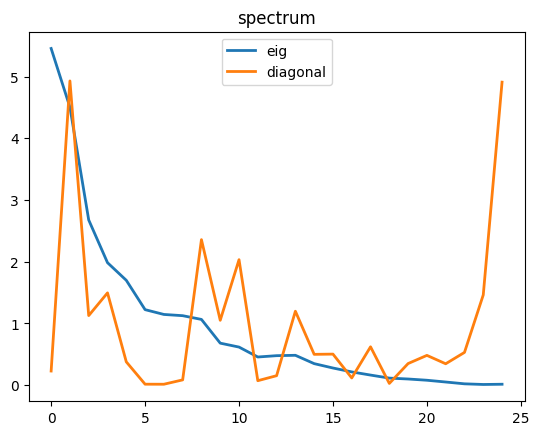

Test mean squared error after transformation: 0.34313298551026744
Simulation: 1
Test mean squared error before transformation: 0.3452781722414127


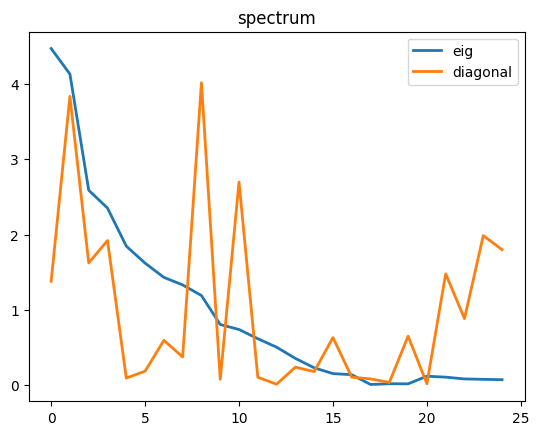

Test mean squared error after transformation: 0.3433975265870515
Simulation: 2
Test mean squared error before transformation: 0.34661977246702375


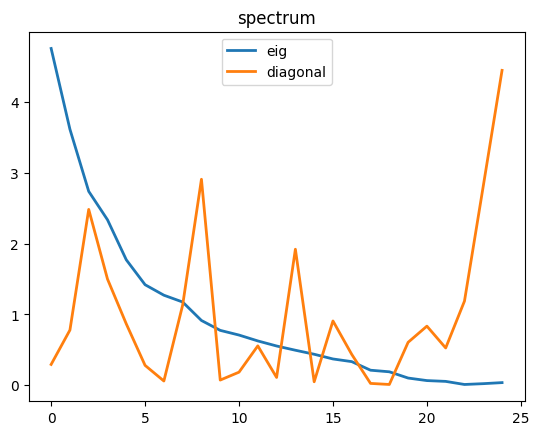

Test mean squared error after transformation: 0.34856192731331886
Simulation: 3
Test mean squared error before transformation: 0.3465080942910936


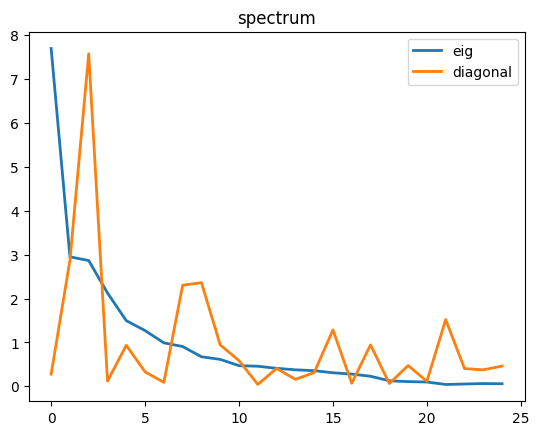

Test mean squared error after transformation: 0.3389125688755092
Simulation: 4
Test mean squared error before transformation: 0.3449145805436619


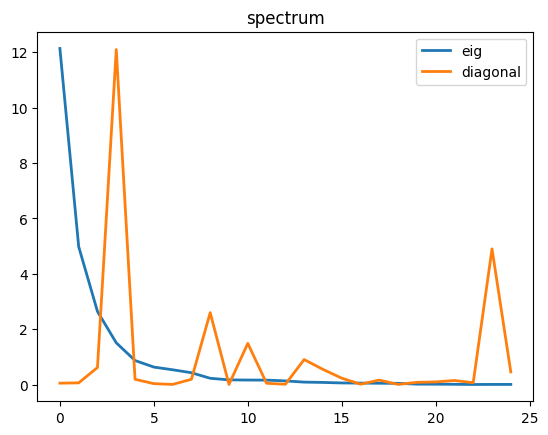

Test mean squared error after transformation: 0.3304103318365272
number of training samples: 1000
Simulation: 0
Test mean squared error before transformation: 0.34040993007669385


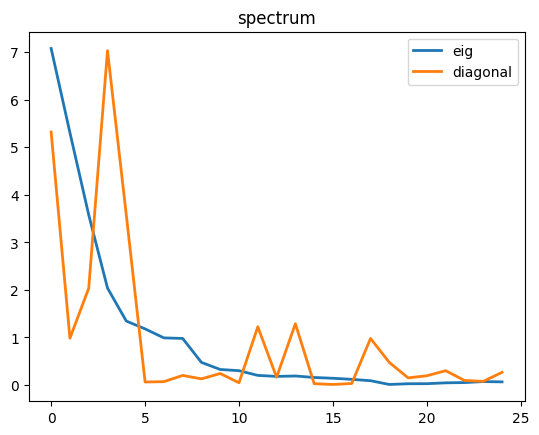

Test mean squared error after transformation: 0.30622494693542124
Simulation: 1
Test mean squared error before transformation: 0.34072721652382215


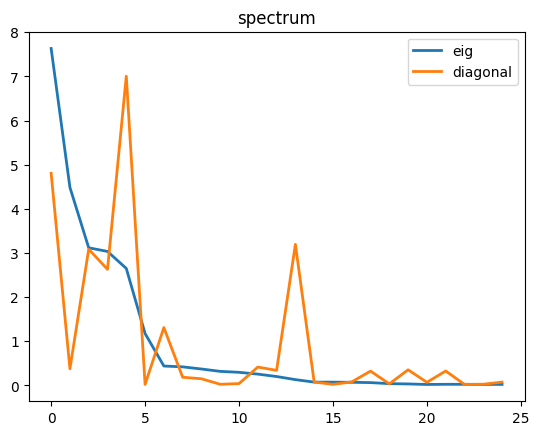

Test mean squared error after transformation: 0.3156930633121391
Simulation: 2
Test mean squared error before transformation: 0.34231540580022285


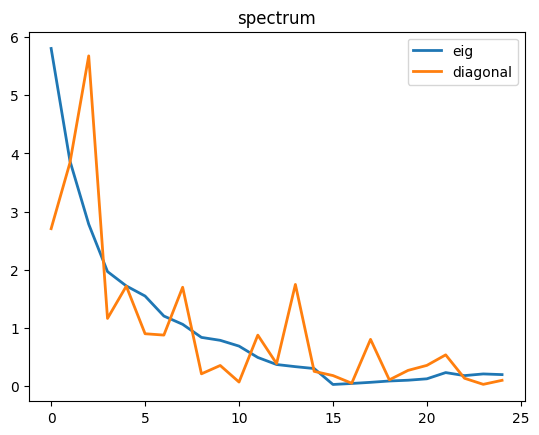

Test mean squared error after transformation: 0.3180714108765597
Simulation: 3
Test mean squared error before transformation: 0.34133919522172096


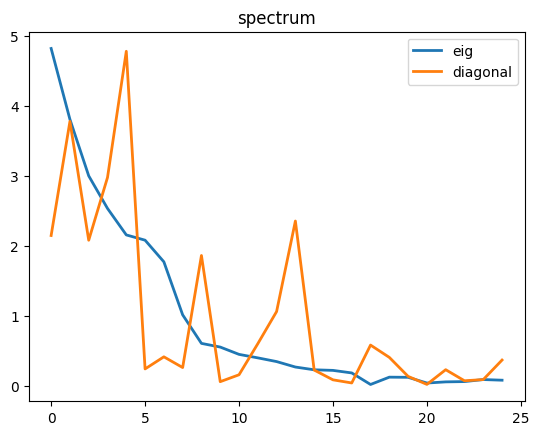

Test mean squared error after transformation: 0.3174767525285964
Simulation: 4
Test mean squared error before transformation: 0.34104891878058624


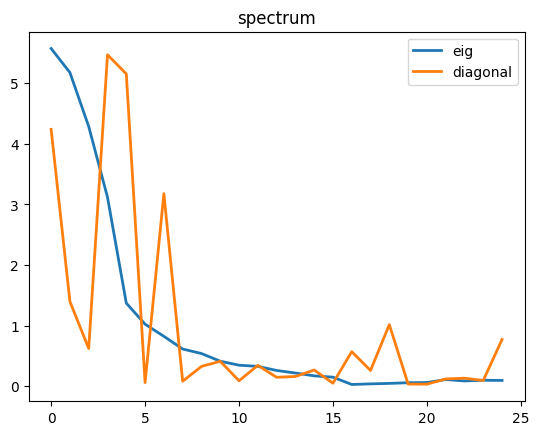

Test mean squared error after transformation: 0.3185314908154889
number of training samples: 2500
Simulation: 0
Test mean squared error before transformation: 0.3421975752260912


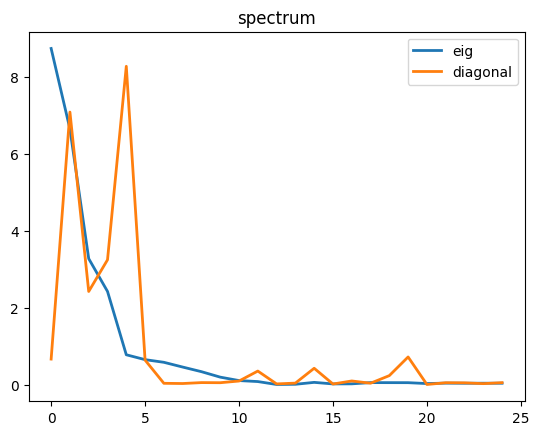

Test mean squared error after transformation: 0.3091649147778692
Simulation: 1
Test mean squared error before transformation: 0.3449860550276961


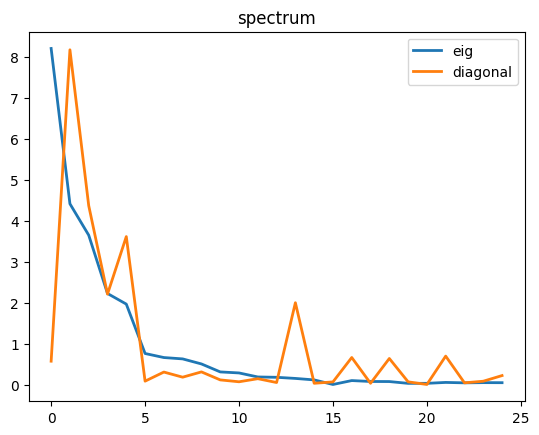

Test mean squared error after transformation: 0.31093996155487436
Simulation: 2
Test mean squared error before transformation: 0.3447320777764907


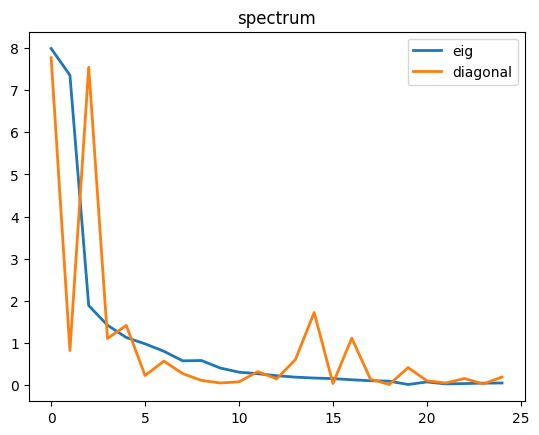

Test mean squared error after transformation: 0.3180400529106283
Simulation: 3
Test mean squared error before transformation: 0.3443260517379775


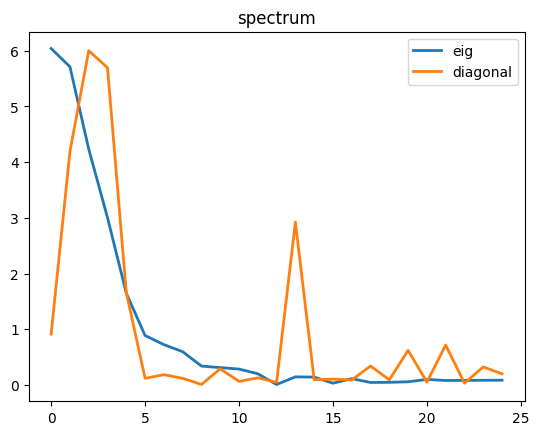

Test mean squared error after transformation: 0.31590473395970403
Simulation: 4
Test mean squared error before transformation: 0.341226085814466


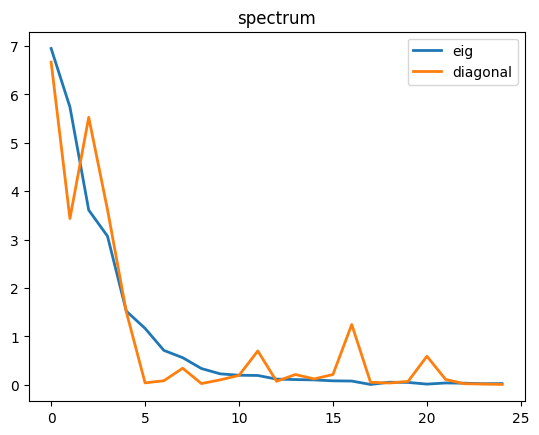

Test mean squared error after transformation: 0.31082380811533683
number of training samples: 5000
Simulation: 0
Test mean squared error before transformation: 0.34341488049918273


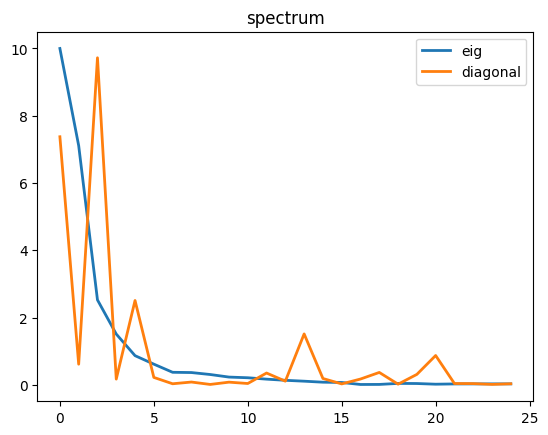

Test mean squared error after transformation: 0.30718728437746406
Simulation: 1
Test mean squared error before transformation: 0.3409963012392671


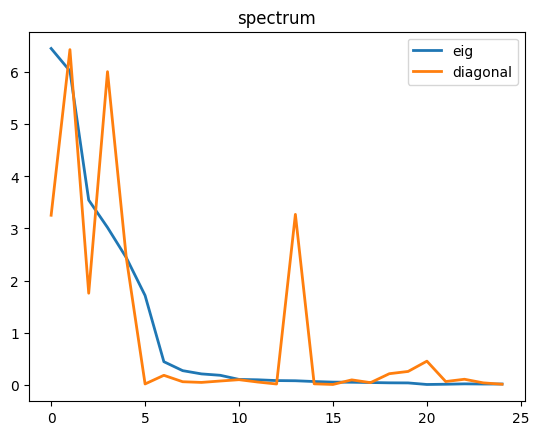

Test mean squared error after transformation: 0.31103796934345984
Simulation: 2
Test mean squared error before transformation: 0.3421794001377715


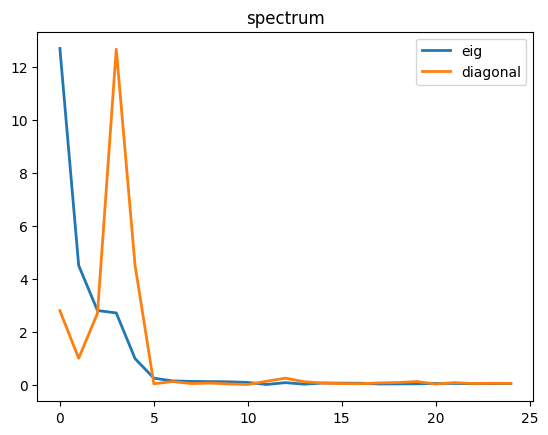

Test mean squared error after transformation: 0.3021972369724337
Simulation: 3
Test mean squared error before transformation: 0.34137076647954173


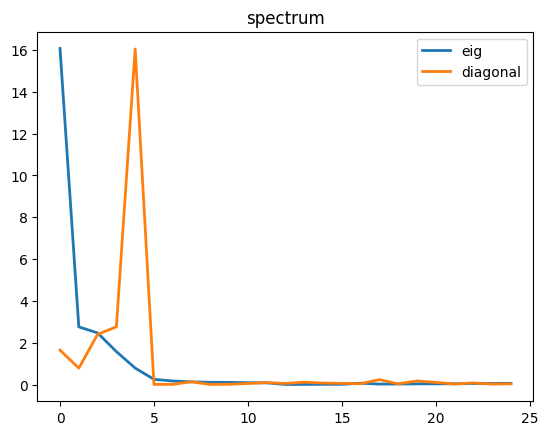

Test mean squared error after transformation: 0.3012820294116424
Simulation: 4
Test mean squared error before transformation: 0.3425330497899134


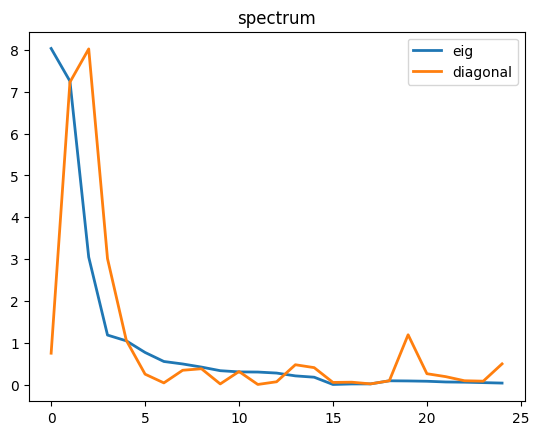

Test mean squared error after transformation: 0.3079833579046339
number of training samples: 7500
Simulation: 0
Test mean squared error before transformation: 0.3418658766879487


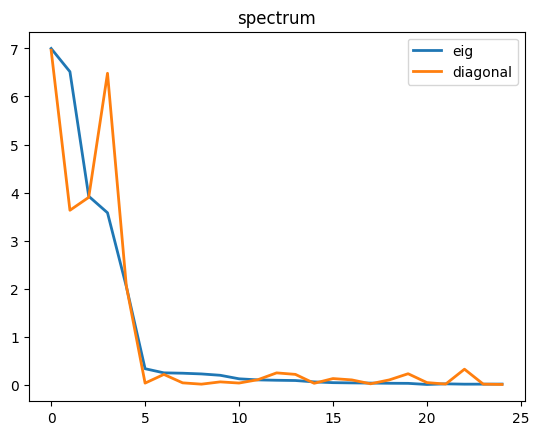

Test mean squared error after transformation: 0.3030462883795706
Simulation: 1
Test mean squared error before transformation: 0.3414015675965502


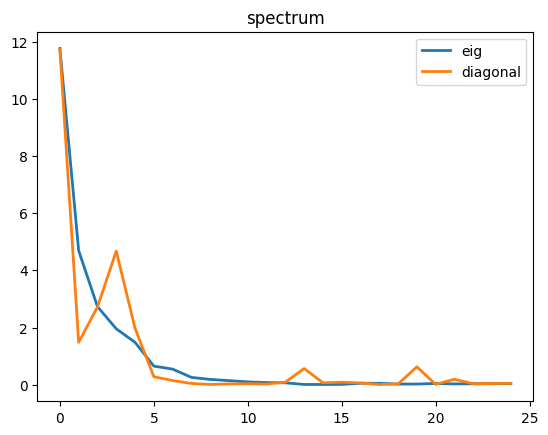

Test mean squared error after transformation: 0.29979602509713116
Simulation: 2
Test mean squared error before transformation: 0.34351023737332415


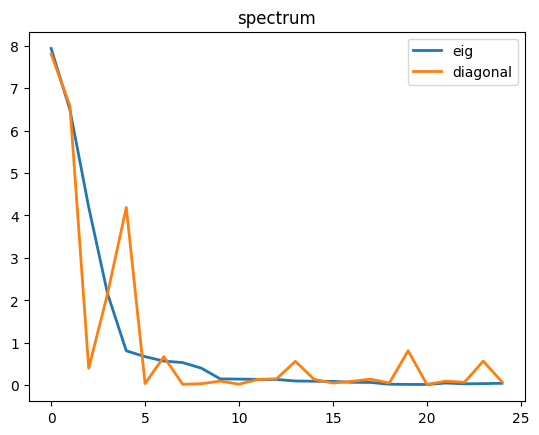

Test mean squared error after transformation: 0.30504849445117754
Simulation: 3
Test mean squared error before transformation: 0.3434671849432767


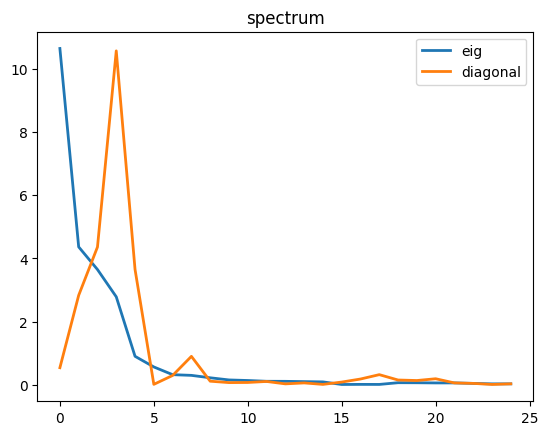

Test mean squared error after transformation: 0.3047752794108621
Simulation: 4
Test mean squared error before transformation: 0.34419306432233265


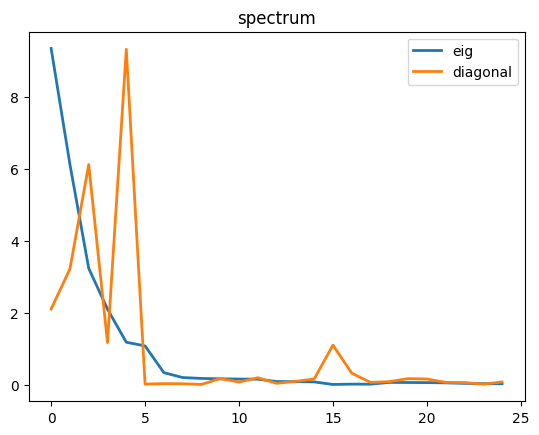

Test mean squared error after transformation: 0.3079111065562259
number of training samples: 10000
Simulation: 0
Test mean squared error before transformation: 0.34397384068374753


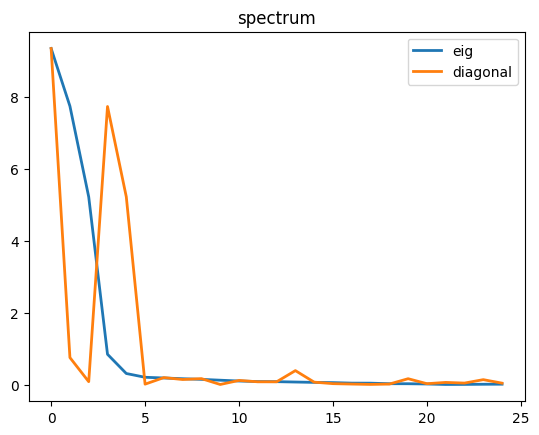

Test mean squared error after transformation: 0.2964261898395843
Simulation: 1
Test mean squared error before transformation: 0.34526826085671464


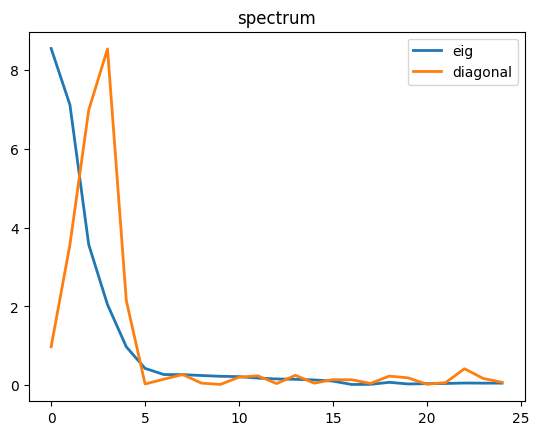

Test mean squared error after transformation: 0.30817029348650304
Simulation: 2
Test mean squared error before transformation: 0.3444082561831935


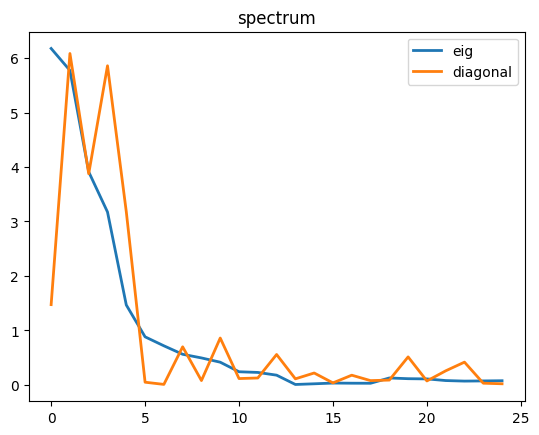

Test mean squared error after transformation: 0.3077206714745371
Simulation: 3
Test mean squared error before transformation: 0.34418886942395444


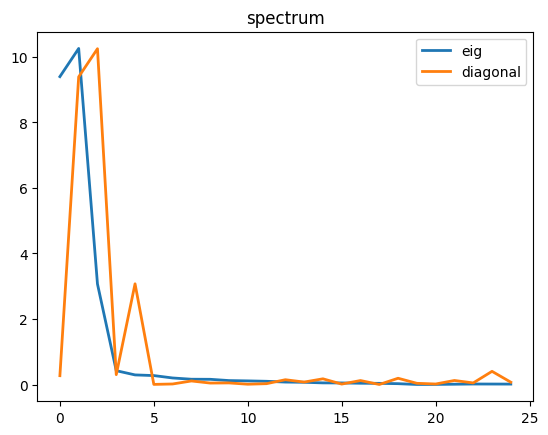

Test mean squared error after transformation: 0.29832929078884474
Simulation: 4
Test mean squared error before transformation: 0.34362289258840284


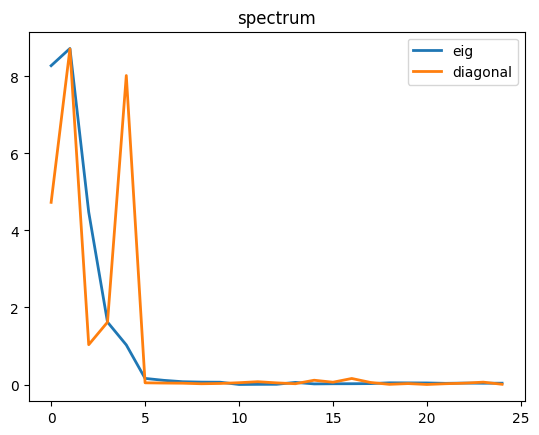

Test mean squared error after transformation: 0.30155558354516643
number of training samples: 15000
Simulation: 0
Test mean squared error before transformation: 0.34468872317465704


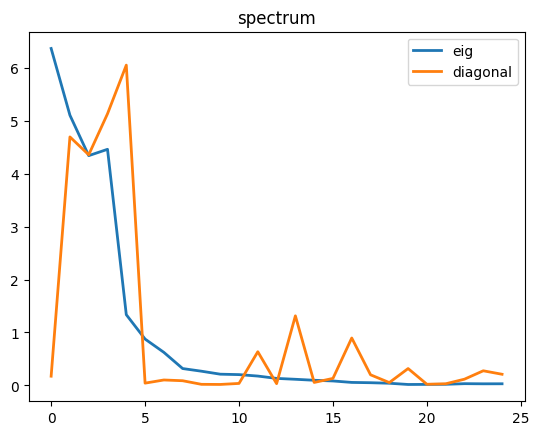

Test mean squared error after transformation: 0.311183480824639
Simulation: 1
Test mean squared error before transformation: 0.344221054632927


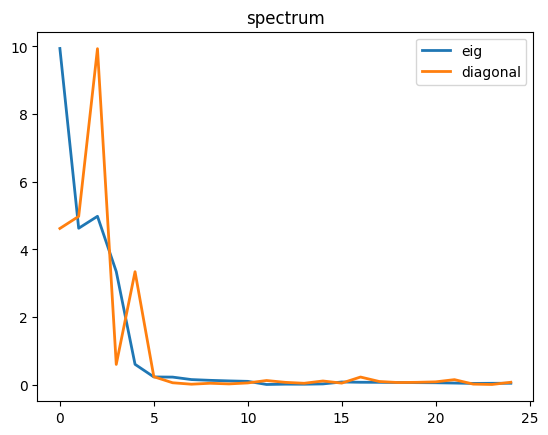

Test mean squared error after transformation: 0.3001115833083726
Simulation: 2
Test mean squared error before transformation: 0.3433923847718526


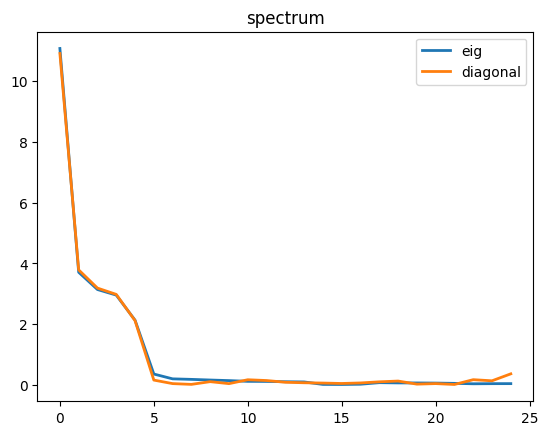

Test mean squared error after transformation: 0.30480689618938595
Simulation: 3
Test mean squared error before transformation: 0.3415741887181624


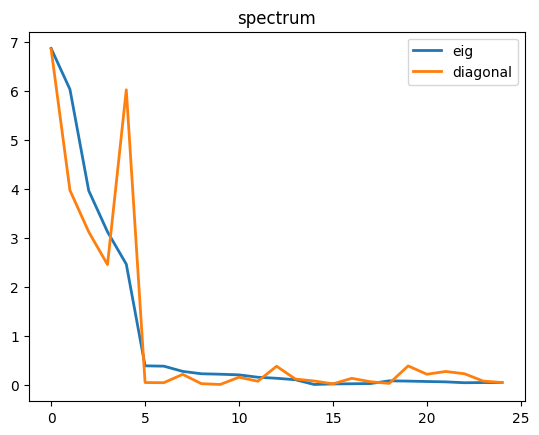

Test mean squared error after transformation: 0.30474182760285307
Simulation: 4
Test mean squared error before transformation: 0.3426874304204665


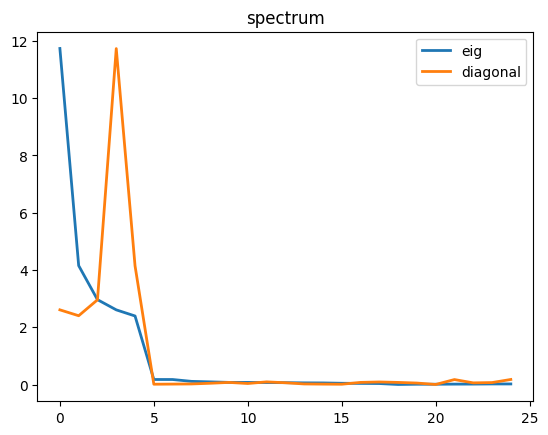

Test mean squared error after transformation: 0.2998146726577552
number of training samples: 20000
Simulation: 0
Test mean squared error before transformation: 0.34361221408348946


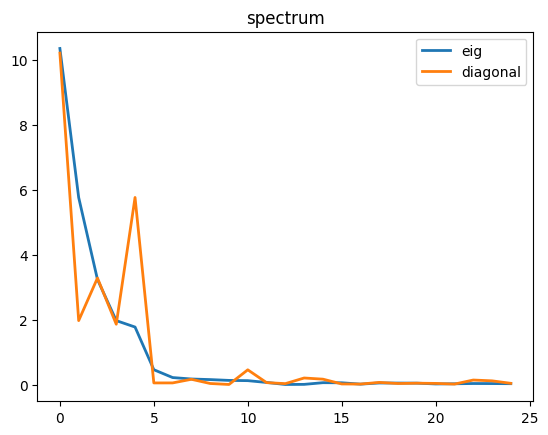

Test mean squared error after transformation: 0.306495226412227
Simulation: 1
Test mean squared error before transformation: 0.34275288511737245


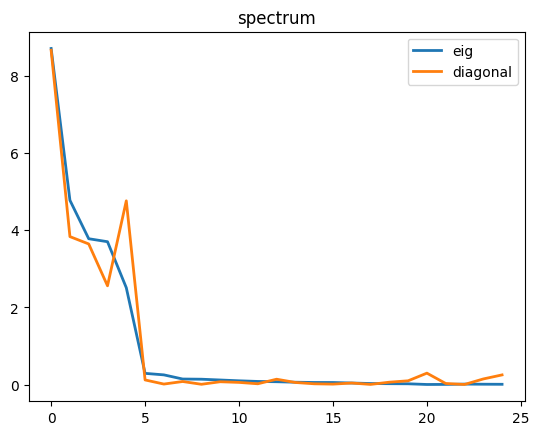

Test mean squared error after transformation: 0.3011656981898629
Simulation: 2
Test mean squared error before transformation: 0.34351776897734126


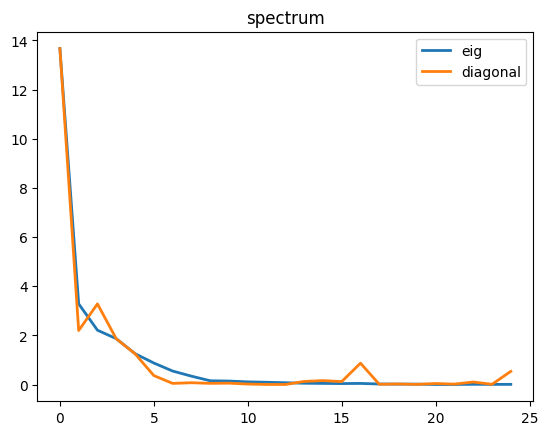

Test mean squared error after transformation: 0.3032927570127349
Simulation: 3
Test mean squared error before transformation: 0.3419867225635895


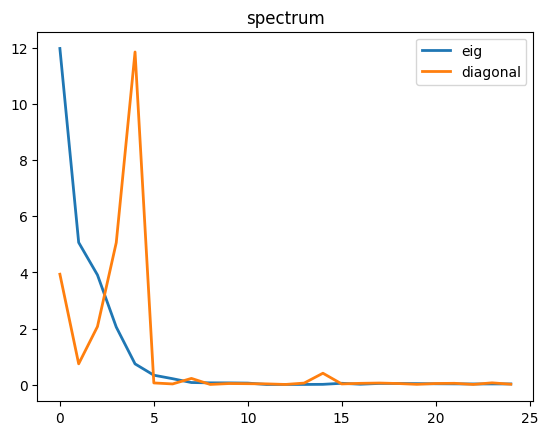

Test mean squared error after transformation: 0.2997941885022424
Simulation: 4
Test mean squared error before transformation: 0.3403291544727502


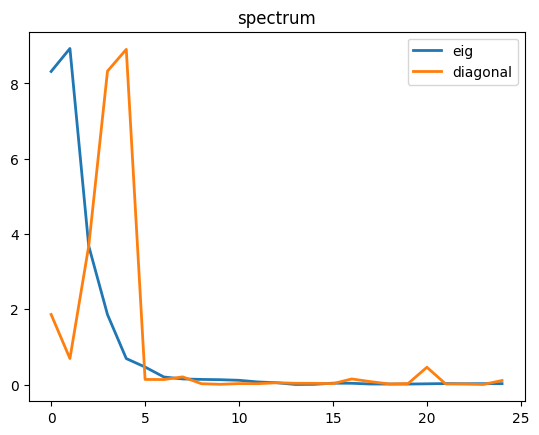

Test mean squared error after transformation: 0.29476386795438086


In [2]:
n = 20000
dim_in = 25
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train)

x_test = np.random.rand(5000,dim_in)*2 - 1
y_test = simulate_y(x_test)

sample_range = [100, 1000, 2500, 5000, 7500, 10000, 15000, 20000]

M = 100                      # number of Mondrian trees to use
lifetime_max = 0.1          # terminal lifetime
weights_lifetime = 2*1e-6   # lifetime for which weights should be plotted
delta = 0.1              # ridge regression delta

stats = []

for n_sim in sample_range:
    print(f"number of training samples: {n_sim}")
    mse = {'n': n_sim, 'before': [], "after": []}
    for round in range(5):
        print(f"Simulation: {round}")
        mse_before, mse_after = simulate(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta, weights_lifetime)
        mse['before'].append(mse_before)
        mse['after'].append(mse_after)
    stats.append(mse)

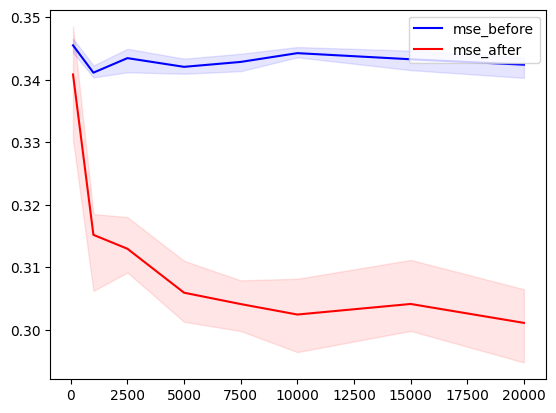

In [3]:
x = sample_range
before = []
before_min = []
before_max = []
after = []
after_min = []
after_max = []

for stat in stats:
    before.append(np.mean(stat['before']))
    before_min.append(np.min(stat['before']))
    before_max.append(np.max(stat['before']))
    after.append(np.mean(stat['after']))
    after_min.append(np.min(stat['after']))
    after_max.append(np.max(stat['after']))

fig, ax = plt.subplots()
ax.plot(x, before, color='b')
ax.plot(x, after, color='r')
ax.fill_between(x, (before_min), (before_max), color='b', alpha=.1)
ax.fill_between(x, (after_min), (after_max), color='r', alpha=.1)

plt.legend(["mse_before", "mse_after"], loc ="upper right")

pickle.dump(stat, open("stat.pk", "wb"))

In [4]:
stats_best = {}
best = {}

for multiplier in range(1,6):
    print(f"lifetime multiplier: {multiplier}")
    stats_best[multiplier] = []
    best[multiplier] = {"mean": [], "min": [], "max": []}
    for n_sim in sample_range:
        stats_temp = []
        print(f"number of training samples: {n_sim}")
        mse = {'n': n_sim, 'best': []}
        for round in range(5):
            print(f"Simulation: {round}")
            mse_best = simulate_best(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max * (multiplier), delta, weights_lifetime)
            mse['best'].append(mse_best)
            print(mse_best)
        stats_best[multiplier].append(mse)
        best[multiplier]["mean"].append(np.mean(mse['best']))
        best[multiplier]["min"].append(np.min(mse['best']))
        best[multiplier]["max"].append(np.max(mse['best']))

pickle.dump(stat, open("stats_best.pk", "wb"))

lifetime multiplier: 1
number of training samples: 100
Simulation: 0
0.3292666225186136
Simulation: 1
0.33088132545167753
Simulation: 2
0.3277277237868074
Simulation: 3
0.33248244699937185
Simulation: 4
0.32660570720908727
number of training samples: 1000
Simulation: 0
0.31394547142916285
Simulation: 1
0.31561248514354145
Simulation: 2
0.31958373692891456
Simulation: 3
0.31946379780914896
Simulation: 4
0.31472665729131055
number of training samples: 2500
Simulation: 0
0.3175191691342811
Simulation: 1
0.32302034063493246
Simulation: 2
0.31695120360467816
Simulation: 3
0.32064816940716717
Simulation: 4
0.3172391560427342
number of training samples: 5000
Simulation: 0
0.32114274715835583
Simulation: 1
0.3205475536759118
Simulation: 2
0.3270037759605739
Simulation: 3
0.3153434339068846
Simulation: 4
0.31454170521620234
number of training samples: 7500
Simulation: 0
0.32213567716769276
Simulation: 1
0.31906258946668775
Simulation: 2
0.3123279327710308
Simulation: 3
0.31307922864931004
Simul

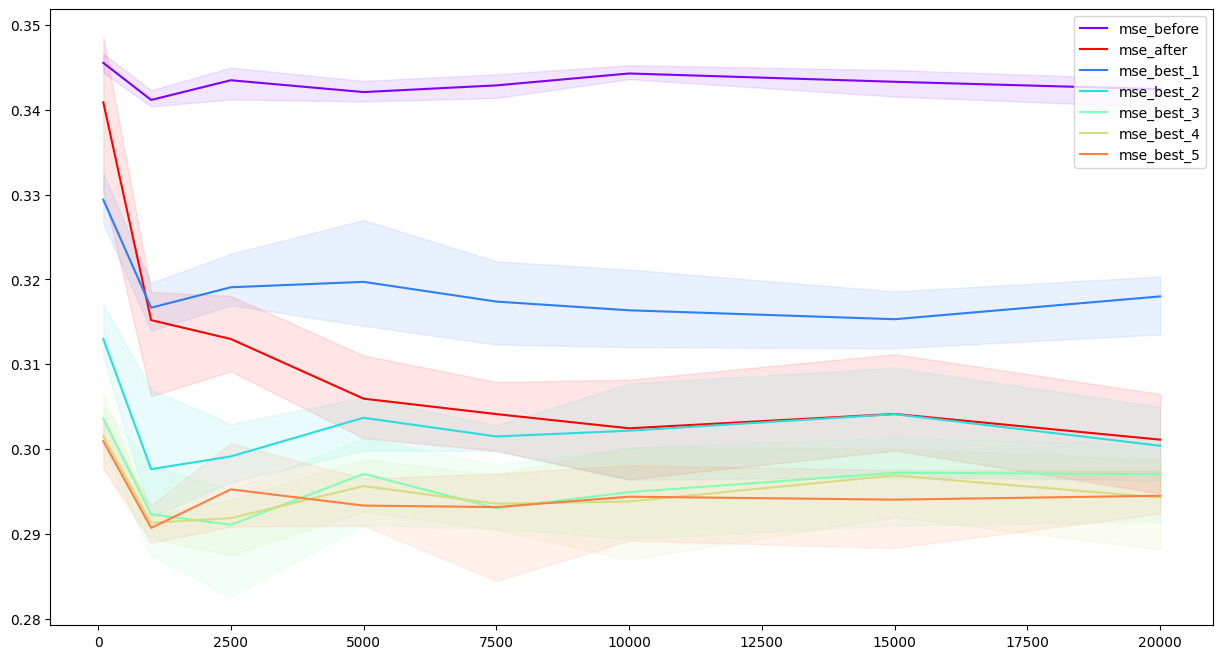

In [6]:
colors = plt.cm.rainbow(np.linspace(0, 1, 7))

fig, ax = plt.subplots(figsize=(15,8))

ax.plot(x, before, color=colors[0])
ax.plot(x, after, color=colors[6])
for multiplier in range(1,6):
    ax.plot(x, best[multiplier]["mean"], color=colors[multiplier])
plt.legend(["mse_before", "mse_after", "mse_best_1", "mse_best_2", "mse_best_3", "mse_best_4", "mse_best_5"], loc ="upper right")
ax.fill_between(x, (before_min), (before_max), color=colors[0], alpha=.1)
ax.fill_between(x, (after_min), (after_max), color=colors[6], alpha=.1)
for multiplier in range(1,6):
    ax.fill_between(x, (best[multiplier]["min"]), (best[multiplier]["max"]), color=colors[multiplier], alpha=.1)